# Analyse Prédictive : Consommation Électrique Théorique (Multi-Département)

Ce notebook a pour objectif d'identifier les modèles prédictifs les plus significatifs pour estimer la consommation électrique théorique des logements.

## 1. Configuration et Chargement des données

Veuillez définir ci-dessous le **code du département** que vous souhaitez analyser.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
# --- CHOIX DU DÉPARTEMENT ---
CODE_DEPARTEMENT = '75'  # Modifiez ici '01', '69', '75', etc.
# ----------------------------

print(f"Département sélectionné : {CODE_DEPARTEMENT}")

# Construction du chemin du fichier : ./01/Dpe_dep_01.csv
# On cherche le fichier dans le sous-dossier portant le code département
search_path = os.path.join(CODE_DEPARTEMENT, f"*Dpe_dep_*{CODE_DEPARTEMENT}*.csv")
found_files = glob.glob(search_path)

if found_files:
    file_path = found_files[0]
    print(f"Chargement du fichier : {file_path}")
    try:
        df = pd.read_csv(file_path, low_memory=False)
        print(f"Données chargées avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes.")
    except Exception as e:
        print(f"Erreur critique lors du chargement : {e}")
        df = pd.DataFrame()
else:
    print(f"ERREUR : Aucun fichier trouvé pour le pattern '{search_path}'.")
    print(f"Vérifiez que le dossier '{CODE_DEPARTEMENT}' existe et contient un CSV 'Dpe_dep_{CODE_DEPARTEMENT}.csv'.")
    df = pd.DataFrame()

Département sélectionné : 75
Chargement du fichier : 75\Dpe_dep_75.csv
Données chargées avec succès : 530000 lignes, 225 colonnes.


## 2. Préparation et Nettoyage des Données

Pour prédire la **consommation électrique théorique (Énergie Primaire)**, nous allons :
1.  **Filtrer** les logements dont l'énergie principale de chauffage est l'électricité.
2.  **Créer des variables simplifiées** compréhensibles par l'utilisateur (ex: Type de chauffage simplifié).
3.  **Sélectionner** les variables explicatives (features) pertinentes.
4.  **Nettoyer** les valeurs manquantes et aberrantes.

In [3]:
if not df.empty:
    # Filtrage pour l'électricité
    # Note: On vérifie si la colonne existe, car le nom peut varier légèrement selon les versions du CSV
    if 'type_energie_principale_chauffage' in df.columns:
        df_elec = df[df['type_energie_principale_chauffage'] == 'Électricité'].copy()
    else:
        print("Attention : Colonne 'type_energie_principale_chauffage' introuvable. Utilisation du dataset complet (risqué).")
        df_elec = df.copy()
        
    print(f"Nombre de logements sélectionnés (Chauffage Élec) : {df_elec.shape[0]}")

    # --- Création de features simplifiées ---

    # 1. Simplification du type de chauffage
    def simplifier_chauffage(val):
        if pd.isna(val):
            return 'Autre/Inconnu'
        val = str(val).lower()
        if 'pac' in val or 'pompe' in val or 'thermodynamique' in val:
            return 'Pompe à Chaleur (PAC)'
        elif 'radiateur' in val or 'convecteur' in val or 'panneau' in val or 'rayonnant' in val or 'standard' in val:
            return 'Radiateur Électrique (Effet Joule)'
        elif 'chaudière' in val:
            return 'Chaudière Électrique'
        else:
            return 'Autre Élec'

    if 'type_generateur_chauffage_principal' in df_elec.columns:
        df_elec['chauffage_simplifie'] = df_elec['type_generateur_chauffage_principal'].apply(simplifier_chauffage)
    else:
        df_elec['chauffage_simplifie'] = 'Inconnu'

    # 2. Logement Traversant
    if 'logement_traversant' in df_elec.columns:
        df_elec['logement_traversant_clean'] = df_elec['logement_traversant'].map({1.0: 'Oui', 0.0: 'Non'}).fillna('Inconnu')
    else:
         df_elec['logement_traversant_clean'] = 'Inconnu'

    # 3. Isolation Toiture
    if 'isolation_toiture' in df_elec.columns:
        df_elec['isolation_toiture_clean'] = df_elec['isolation_toiture'].map({1.0: 'Isolé', 0.0: 'Non Isolé'}).fillna('Inconnu')
    else:
        df_elec['isolation_toiture_clean'] = 'Inconnu'


    # Sélection des features (X) et de la target (y)
    target_col = 'conso_5_usages_ep' # Updated to Primary Energy

    # Liste enrichie de variables "connues de l'utilisateur"
    features_num = [
        'surface_habitable_logement',
        'annee_construction', 
        'hauteur_sous_plafond'
    ]

    features_cat = [
        'type_batiment', 
        'zone_climatique', 
        'classe_altitude',
        'chauffage_simplifie',        
        'logement_traversant_clean',  
        'isolation_toiture_clean'     
    ]
    
    # Filtrer uniquement les colonnes présentes
    features_num = [c for c in features_num if c in df_elec.columns]
    features_cat = [c for c in features_cat if c in df_elec.columns]

    print("Variables numériques utilisées :", features_num)
    print("Variables catégorielles utilisées :", features_cat)

    # Création du dataset final
    available_cols = features_num + features_cat
    X = df_elec[available_cols]
    
    if target_col in df_elec.columns:
        y = df_elec[target_col]
        # Nettoyage rapide des cibles aberrantes
        mask = (y > 0) & (y < 100000)
        X = X[mask]
        y = y[mask]
        print(f"Données après nettoyage target : {X.shape[0]}")
    else:
        print(f"ERREUR : La colonne cible '{target_col}' est introuvable.")
        y = pd.Series()

Nombre de logements sélectionnés (Chauffage Élec) : 230526
Variables numériques utilisées : ['surface_habitable_logement', 'annee_construction', 'hauteur_sous_plafond']
Variables catégorielles utilisées : ['type_batiment', 'zone_climatique', 'classe_altitude', 'chauffage_simplifie', 'logement_traversant_clean', 'isolation_toiture_clean']
Données après nettoyage target : 227939


In [4]:
if not df.empty and not y.empty:
    # Pipeline de Prétraitement

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler()) 
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore')) 
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, features_num),
            ('cat', categorical_transformer, features_cat)
        ])

    # Split Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Shape Train:", X_train.shape, "Shape Test:", X_test.shape)

Shape Train: (182351, 9) Shape Test: (45588, 9)


## 3. Entraînement et Comparaison des Modèles

Nous allons tester 4 modèles :
1.  **Régression Linéaire** (Baseline)
2.  **Ridge Regression** (Linéaire avec régularisation)
3.  **Random Forest** (Non-linéaire, robuste)
4.  **Gradient Boosting (XGBoost/sklearn)** (Souvent le plus performant pour les données tabulaires)

In [5]:
if not df.empty and not y.empty:
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
    }

    results = {}

    for name, model in models.items():
        # Création du pipeline complet
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        # Entraînement
        clf.fit(X_train, y_train)
        
        # Prédiction
        y_pred = clf.predict(X_test)
        
        # Evaluation
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {"RMSE": rmse, "R2": r2, "Model": clf}
        print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}")

Linear Regression: RMSE = 5501.08, R2 = 0.5318
Ridge: RMSE = 5501.10, R2 = 0.5318
Random Forest: RMSE = 5131.04, R2 = 0.5927
Gradient Boosting: RMSE = 5087.22, R2 = 0.5996


## 4. Analyse des Résultats et Importance des Variables

Regardons quel modèle est le plus performant et quelles variables pèsent le plus dans la prédiction.

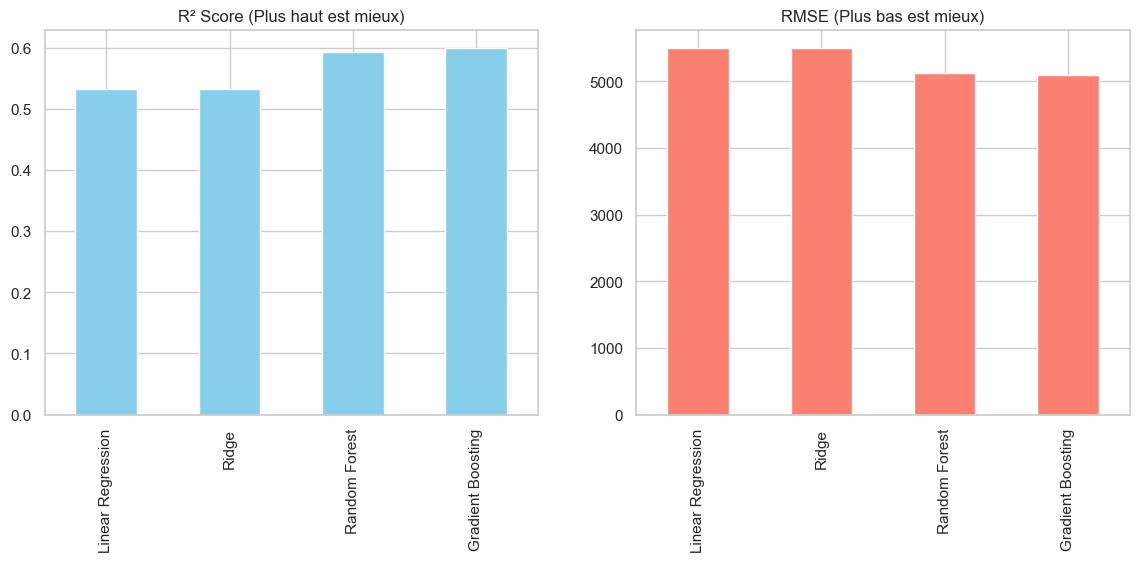

C:\Users\User\AppData\Local\Temp\ipykernel_16048\628446875.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


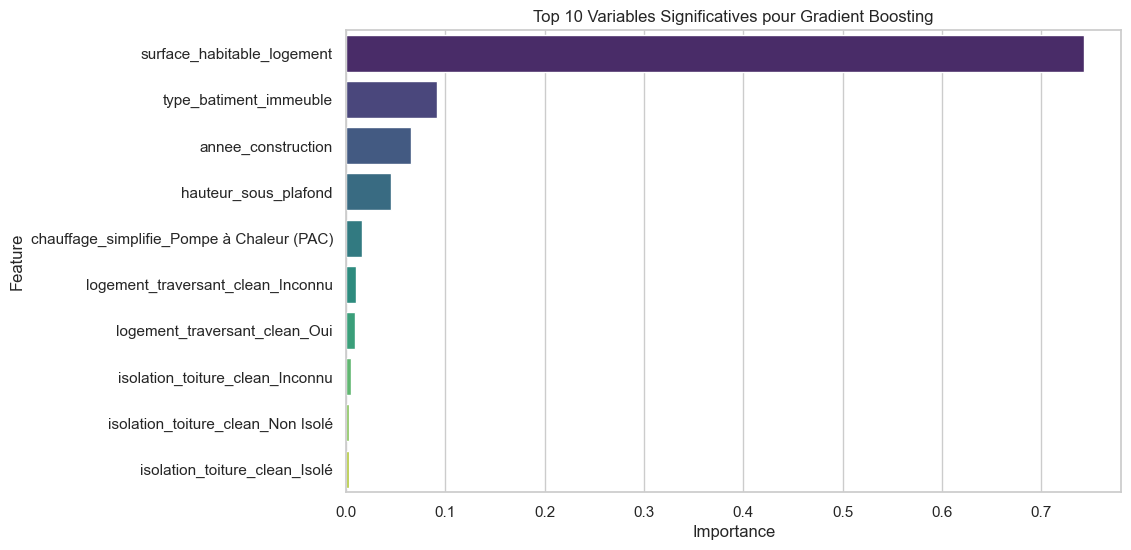

In [6]:
if not df.empty and not y.empty:
    # Comparaison Graphique
    metrics_df = pd.DataFrame(results).T[['RMSE', 'R2']]

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    metrics_df['R2'].plot(kind='bar', ax=ax[0], color='skyblue', title='R² Score (Plus haut est mieux)')
    metrics_df['RMSE'].plot(kind='bar', ax=ax[1], color='salmon', title='RMSE (Plus bas est mieux)')
    plt.show()

    # Focus sur Feature Importance du meilleur modèle (souvent RF ou GB)
    best_model_name = metrics_df['R2'].idxmax()
    best_pipeline = results[best_model_name]['Model']

    if best_model_name in ["Random Forest", "Gradient Boosting"]:
        # Récupération des noms de features après encodage
        importances = best_pipeline.named_steps['classifier'].feature_importances_
        
        # Noms des features
        ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feat_names = ohe.get_feature_names_out(features_cat)
        all_feat_names = features_num + list(cat_feat_names)
        
        feat_imp_df = pd.DataFrame({'Feature': all_feat_names, 'Importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
        plt.title(f'Top 10 Variables Significatives pour {best_model_name}')
        plt.show()

In [7]:
if not df.empty and not y.empty and best_model_name in ["Random Forest", "Gradient Boosting"]:
    # Recréation du DF complet trié sans limite
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feat_names = ohe.get_feature_names_out(features_cat)
    all_feat_names = features_num + list(cat_feat_names)
    
    feat_imp_df_full = pd.DataFrame({'Feature': all_feat_names, 'Importance': importances})
    feat_imp_df_full = feat_imp_df_full.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Calcul cumulé
    feat_imp_df_full['Cumulative_Importance'] = feat_imp_df_full['Importance'].cumsum()
    
    thresholds = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99] # Inclut 99%
    
    print("=== Analyse de la Significativité Cumulée ===")
    for thresh in thresholds:
        # Trouver l'index où la somme cumulée dépasse le seuil
        matches = feat_imp_df_full[feat_imp_df_full['Cumulative_Importance'] >= thresh]
        
        if not matches.empty:
            idx = matches.index[0]
            selected_features = feat_imp_df_full.loc[:idx, 'Feature'].tolist()
            cum_score = feat_imp_df_full.loc[idx, 'Cumulative_Importance']
            
            print(f"\n> Pour atteindre {thresh*100:.0f}% de significativité (Score réel: {cum_score:.4f}) :")
            print(f"  {len(selected_features)} variables nécessaires : {', '.join(selected_features)}")
        else:
             print(f"\n> Impossible d'atteindre {thresh*100:.0f}% avec les variables actuelles.")
else:
    print("L'analyse d'importance cumulée nécessite un modèle type arbre (Random Forest ou Gradient Boosting).")

=== Analyse de la Significativité Cumulée ===

> Pour atteindre 50% de significativité (Score réel: 0.7433) :
  1 variables nécessaires : surface_habitable_logement

> Pour atteindre 60% de significativité (Score réel: 0.7433) :
  1 variables nécessaires : surface_habitable_logement

> Pour atteindre 70% de significativité (Score réel: 0.7433) :
  1 variables nécessaires : surface_habitable_logement

> Pour atteindre 80% de significativité (Score réel: 0.8351) :
  2 variables nécessaires : surface_habitable_logement, type_batiment_immeuble

> Pour atteindre 90% de significativité (Score réel: 0.9009) :
  3 variables nécessaires : surface_habitable_logement, type_batiment_immeuble, annee_construction

> Pour atteindre 95% de significativité (Score réel: 0.9627) :
  5 variables nécessaires : surface_habitable_logement, type_batiment_immeuble, annee_construction, hauteur_sous_plafond, chauffage_simplifie_Pompe à Chaleur (PAC)

> Pour atteindre 99% de significativité (Score réel: 0.9916) :

## Conclusion

Les résultats ci-dessus montrent quel algorithme offre la meilleure précision pour estimer la consommation électrique.
Le **R²** indique la part de variance expliquée par le modèle.
L'**RMSE** indique l'erreur moyenne en kWhEP/an (ou unité de la cible).

L'analyse d'importance des variables permet de comprendre quels facteurs (Surface, isolation, etc.) influencent le plus cette consommation **au niveau local dans le département choisi**.

## 5. Analyse Nationale Multi-Départements (01, 12, 35, 75, 91)

Cette section agrège les données des cinq départements cibles pour former un dataset représentatif à l'échelle nationale.
L'objectif est d'identifier les variables explicatives permettant d'atteindre **95% de significativité** sur cet ensemble varié.

In [8]:
# --- 1. CHARGEMENT ET AGGRÉGATION DES DONNÉES ---
TARGET_DEPARTMENTS = ['01', '12', '35', '75', '91']
df_list = []

print("Démarrage du chargement multi-départements...")
for code in TARGET_DEPARTMENTS:
    # Recherche du fichier pattern ./CODE/Dpe_dep_CODE.csv
    search_path = os.path.join(code, f"*Dpe_dep_*{code}*.csv")
    found = glob.glob(search_path)
    if found:
        print(f"[{code}] Chargement : {found[0]}")
        try:
            tmp_df = pd.read_csv(found[0], low_memory=False)
            tmp_df['code_departement_source'] = code 
            df_list.append(tmp_df)
        except Exception as e:
            print(f"[{code}] Erreur : {e}")
    else:
        print(f"[{code}] Fichier non trouvé ({search_path})")

if df_list:
    df_national = pd.concat(df_list, ignore_index=True)
    print(f"\n>>> Dataset National créé : {df_national.shape[0]} lignes, {df_national.shape[1]} colonnes.")
else:
    print("\nERREUR : Aucun données chargées.")
    df_national = pd.DataFrame()

Démarrage du chargement multi-départements...
[01] Chargement : 01\Dpe_dep_01.csv
[12] Chargement : 12\Dpe_dep_12.csv
[35] Chargement : 35\Dpe_dep_35.csv
[75] Chargement : 75\Dpe_dep_75.csv
[91] Chargement : 91\Dpe_dep_91.csv

>>> Dataset National créé : 816000 lignes, 227 colonnes.


In [9]:
# --- 2. PRÉPARATION ET MODÉLISATION ---
if not df_national.empty:
    # Filtre Électricité
    col_energ = 'type_energie_principale_chauffage'
    if col_energ in df_national.columns:
        df_nat_elec = df_national[df_national[col_energ] == 'Électricité'].copy()
    else:
        df_nat_elec = df_national.copy()
    
    print(f"Logements chauffés à l'électricité : {df_nat_elec.shape[0]}")

    # Application des simplifications (fonctions définies précédemment)
    if 'type_generateur_chauffage_principal' in df_nat_elec.columns:
        df_nat_elec['chauffage_simplifie'] = df_nat_elec['type_generateur_chauffage_principal'].apply(simplifier_chauffage)
    else:
        df_nat_elec['chauffage_simplifie'] = 'Inconnu'

    if 'logement_traversant' in df_nat_elec.columns:
        df_nat_elec['logement_traversant_clean'] = df_nat_elec['logement_traversant'].map({1.0: 'Oui', 0.0: 'Non'}).fillna('Inconnu')
    else:
         df_nat_elec['logement_traversant_clean'] = 'Inconnu'

    if 'isolation_toiture' in df_nat_elec.columns:
        df_nat_elec['isolation_toiture_clean'] = df_nat_elec['isolation_toiture'].map({1.0: 'Isolé', 0.0: 'Non Isolé'}).fillna('Inconnu')
    else:
        df_nat_elec['isolation_toiture_clean'] = 'Inconnu'
        
    # Sélection Features & Target
    nat_feat_num = [c for c in features_num if c in df_nat_elec.columns]
    nat_feat_cat = [c for c in features_cat if c in df_nat_elec.columns]
    
    X_nat = df_nat_elec[nat_feat_num + nat_feat_cat]
    
    if target_col in df_nat_elec.columns:
        y_nat = df_nat_elec[target_col]
        # Nettoyage Outliers Target
        mask_nat = (y_nat > 0) & (y_nat < 100000)
        X_nat = X_nat[mask_nat]
        y_nat = y_nat[mask_nat]
        print(f"Données finales pour analyse : {X_nat.shape[0]} logements.")

        # Pipeline & Entraînement
        nat_preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, nat_feat_num),
                ('cat', categorical_transformer, nat_feat_cat)
            ])
        
        X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_nat, y_nat, test_size=0.2, random_state=42)
        
        nat_results = {}
        print("\nComparaison des modèles (National)...")
        for name, model in models.items():
            clf_n = Pipeline(steps=[('preprocessor', nat_preprocessor),
                                  ('classifier', model)])
            clf_n.fit(X_train_n, y_train_n)
            y_pred_n = clf_n.predict(X_test_n)
            rmse_n = np.sqrt(mean_squared_error(y_test_n, y_pred_n))
            r2_n = r2_score(y_test_n, y_pred_n)
            nat_results[name] = {"RMSE": rmse_n, "R2": r2_n, "Model": clf_n}
            print(f" - {name}: R²={r2_n:.4f}, RMSE={rmse_n:.0f}")

Logements chauffés à l'électricité : 348727
Données finales pour analyse : 345117 logements.

Comparaison des modèles (National)...
 - Linear Regression: R²=0.5867, RMSE=6317
 - Ridge: R²=0.5867, RMSE=6317
 - Random Forest: R²=0.6627, RMSE=5706
 - Gradient Boosting: R²=0.6706, RMSE=5640


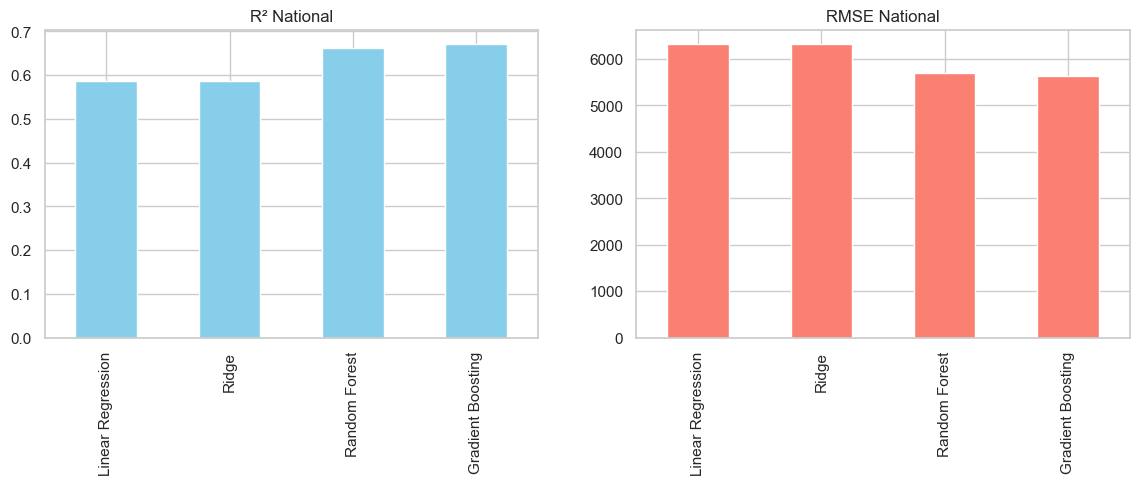


Modèle retenu pour l'analyse : Gradient Boosting

=== OBSERVATION : VARIABLES POUR 95% DE SIGNIFICATIVITÉ (NATIONAL) ===
> 7 variables retenues.
 - surface_habitable_logement               (Imp: 67.1%, Cumul: 67.1%)
 - type_batiment_immeuble                   (Imp: 9.7%, Cumul: 76.9%)
 - annee_construction                       (Imp: 7.8%, Cumul: 84.6%)
 - chauffage_simplifie_Pompe à Chaleur (PAC) (Imp: 5.6%, Cumul: 90.2%)
 - hauteur_sous_plafond                     (Imp: 2.3%, Cumul: 92.5%)
 - type_batiment_appartement                (Imp: 1.7%, Cumul: 94.2%)
 - isolation_toiture_clean_Non Isolé        (Imp: 1.1%, Cumul: 95.3%)


C:\Users\User\AppData\Local\Temp\ipykernel_16048\1409337150.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=significant_vars, palette='viridis')


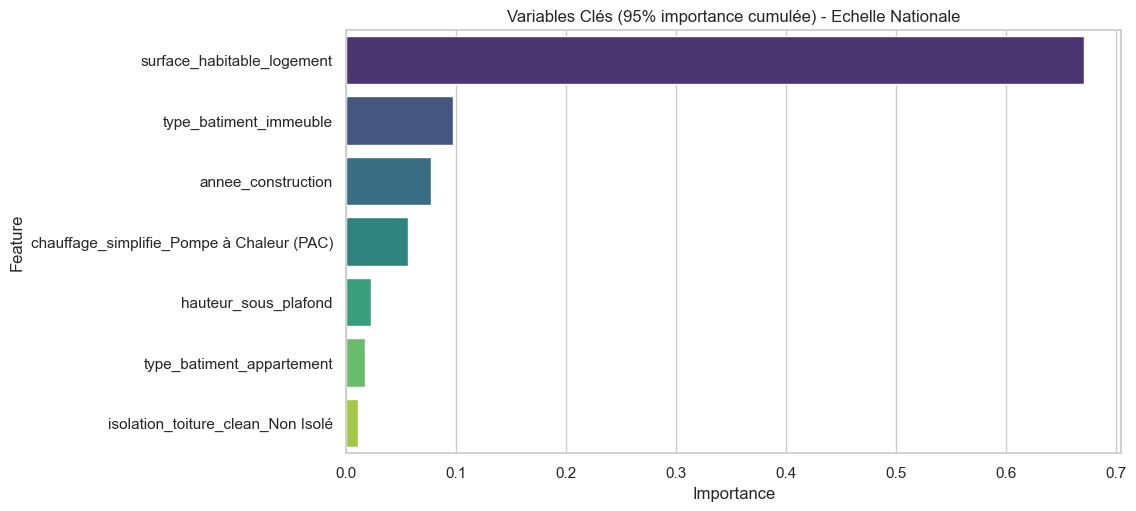

In [10]:
# --- 3. SÉLECTION DES VARIABLES (SEUIL 95%) ---
if 'nat_results' in locals() and nat_results:
    # Graphique Performance
    nat_metrics = pd.DataFrame(nat_results).T[['RMSE', 'R2']]
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    nat_metrics['R2'].plot(kind='bar', ax=ax[0], color='skyblue', title='R² National')
    nat_metrics['RMSE'].plot(kind='bar', ax=ax[1], color='salmon', title='RMSE National')
    plt.show()

    # Feature Selection
    best_nat_model = nat_metrics['R2'].idxmax()
    print(f"\nModèle retenu pour l'analyse : {best_nat_model}")
    
    if best_nat_model in ["Random Forest", "Gradient Boosting"]:
        best_pipe_n = nat_results[best_nat_model]['Model']
        importances_n = best_pipe_n.named_steps['classifier'].feature_importances_
        
        ohe_n = best_pipe_n.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_names_n = ohe_n.get_feature_names_out(nat_feat_cat)
        all_names_n = nat_feat_num + list(cat_names_n)
        
        nat_imp_df = pd.DataFrame({'Feature': all_names_n, 'Importance': importances_n})
        nat_imp_df = nat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
        nat_imp_df['Cumulative'] = nat_imp_df['Importance'].cumsum()
        
        # Seuil 95%
        try:
            cut_idx = nat_imp_df[nat_imp_df['Cumulative'] >= 0.95].index[0]
            significant_vars = nat_imp_df.loc[:cut_idx]
        except IndexError:
            significant_vars = nat_imp_df # Toutes si 95% jamais atteint (rare)
        
        print(f"\n=== OBSERVATION : VARIABLES POUR 95% DE SIGNIFICATIVITÉ (NATIONAL) ===")
        print(f"> {len(significant_vars)} variables retenues.")
        for idx, row in significant_vars.iterrows():
            print(f" - {row['Feature']:<40} (Imp: {row['Importance']:.1%}, Cumul: {row['Cumulative']:.1%})")
            
        plt.figure(figsize=(10, len(significant_vars)/2 + 2))
        sns.barplot(x='Importance', y='Feature', data=significant_vars, palette='viridis')
        plt.title('Variables Clés (95% importance cumulée) - Echelle Nationale')
        plt.show()
    else:
        print("Le meilleur modèle n'est pas basé sur des arbres (pas de feature_importances_).")


=== TOP 30 VARIABLES LES PLUS IMPORTANTES ===
1. surface_habitable_logement                         (Importance : 67.12%)
2. type_batiment_immeuble                             (Importance : 9.73%)
3. annee_construction                                 (Importance : 7.76%)
4. chauffage_simplifie_Pompe à Chaleur (PAC)          (Importance : 5.59%)
5. hauteur_sous_plafond                               (Importance : 2.27%)
6. type_batiment_appartement                          (Importance : 1.73%)
7. isolation_toiture_clean_Non Isolé                  (Importance : 1.07%)
8. zone_climatique_H1a                                (Importance : 0.71%)
9. classe_altitude_inférieur à 400m                   (Importance : 0.69%)
10. type_batiment_maison                               (Importance : 0.50%)
11. logement_traversant_clean_Oui                      (Importance : 0.50%)
12. isolation_toiture_clean_Isolé                      (Importance : 0.44%)
13. logement_traversant_clean_Inconnu            

C:\Users\User\AppData\Local\Temp\ipykernel_16048\1956548533.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_30, palette='magma')


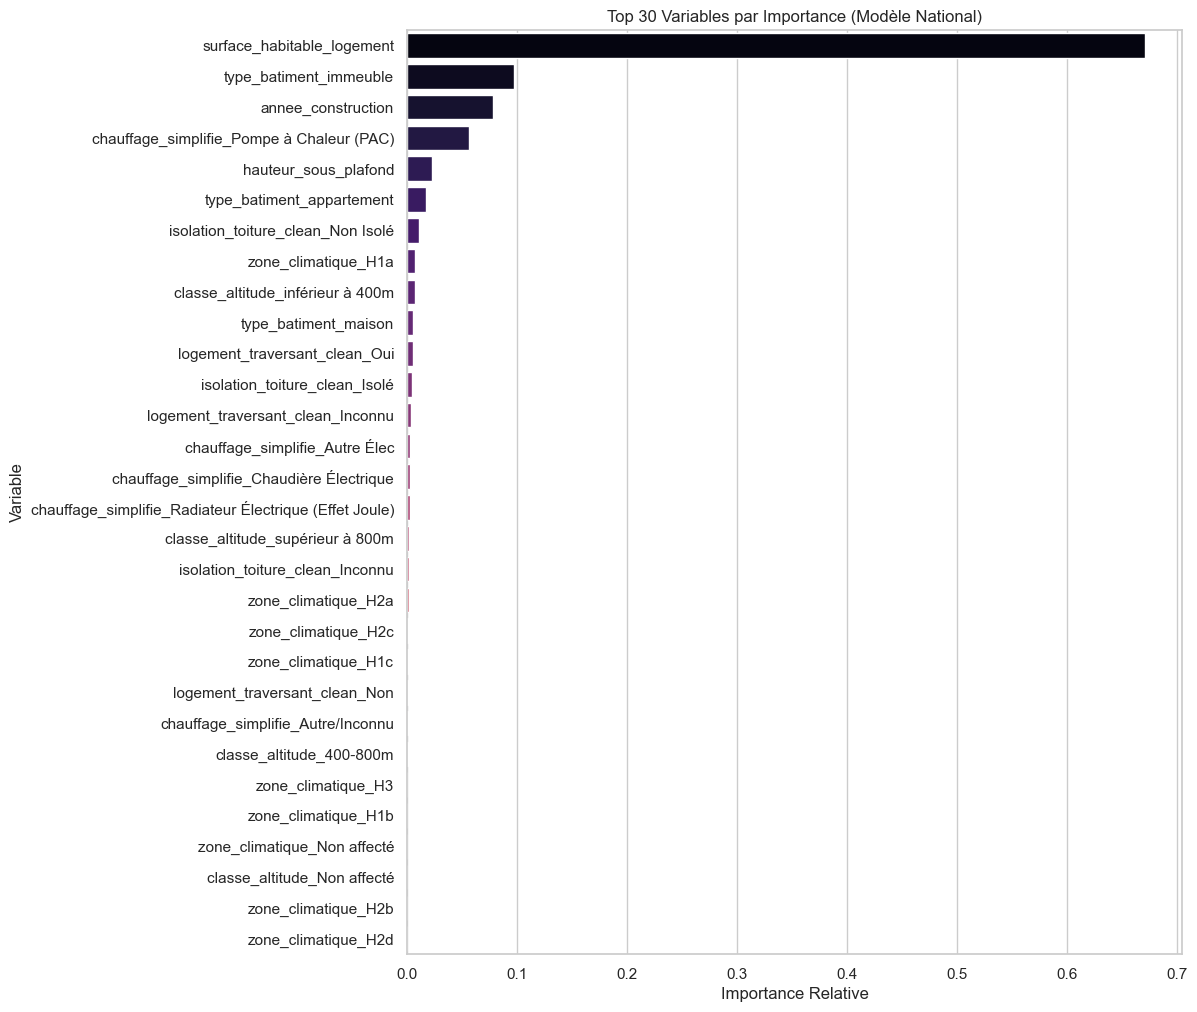

In [11]:
# --- 4. FOCUS SUR LES 30 VARIABLES LES PLUS SIGNIFICATIVES ---
if 'nat_imp_df' in locals():
    top_30 = nat_imp_df.head(30).copy()
    
    print("\n=== TOP 30 VARIABLES LES PLUS IMPORTANTES ===")
    for i, (idx, row) in enumerate(top_30.iterrows(), 1):
        print(f"{i}. {row['Feature']:<50} (Importance : {row['Importance']:.2%})")
        
    # Visualisation
    plt.figure(figsize=(10, 12))
    sns.barplot(x='Importance', y='Feature', data=top_30, palette='magma')
    plt.title('Top 30 Variables par Importance (Modèle National)')
    plt.xlabel('Importance Relative')
    plt.ylabel('Variable')
    plt.show()
else:
    print("Erreur : Le dataframe 'nat_imp_df' n'existe pas. Veuillez lancer la modélisation ci-dessus.")